# IEA Scenario - Skills Demand Changes
Felix Zaussinger | 09.08.2021

## Core Analysis Goal(s)
1. Empirically implement IEA scenario based on occupation - energy vector mapping

## Key Insight(s)
1.

In [73]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define directory structure

In [74]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

### Read data

In [75]:
df_iea = pd.read_excel(
    os.path.join(data_raw, "iea_nze_2050", "NZE2021_AnnexA_occupation_matching_merged.xlsx"),
    sheet_name="Occupations_v2",
    header=1,
    #dtype={"id": np.int16, "isco_level_4": np.int16}
)

In [76]:
skills = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skills_en.csv"))

In [77]:
occ_skills_matrix = pd.read_pickle(
        os.path.join(project_dir, "data", "processed", "adjacency_matrix.pkl")
)

occ_skills_matrix_eo = pd.read_pickle(
        os.path.join(project_dir, "data", "processed", "adjacency_matrix_essential_optional.pkl")
)

In [78]:
# weights: essential = 1, optional = 0.5
occ_skills_matrix_eo = occ_skills_matrix_eo.replace(to_replace=2, value=0.5)

In [79]:
occ_skills_matrix_sub = occ_skills_matrix.loc[df_iea.concept_uri.values, :]
occ_skills_matrix_eo_sub = occ_skills_matrix_eo.loc[df_iea.concept_uri.values, :]

### Project skills demand changes with uniform occ-skills matrix

In [80]:
#pc_change_2030 = df_iea["tes_pc_2019_2030"] * 100
#pc_change_2030_mat = np.tile(pc_change_2030.values, (occ_skills_matrix_sub.shape[1],1)).transpose()
#occ_skills_matrix_sub_2030 = occ_skills_matrix_sub * pc_change_2030_mat
#skills["demand_change_2030"] = occ_skills_matrix_sub_2030.sum(axis=0).values

### Project skills demand changes with essential/optional occ-skills matrix
- preferred option

In [81]:
cols = df_iea.columns[df_iea.columns.str.startswith("tes")]

for col in cols:
    # create matrix with tes numbers repeated across cols of occ-skills matrix
    pc_change_2030_mat = np.tile(df_iea[col].multiply(100).values, (occ_skills_matrix_eo_sub.shape[1],1)).transpose()

    # multiply tes numbers with occ-skills matrix (optional skills downweighted)
    occ_skills_matrix_sub_2030 = occ_skills_matrix_eo_sub * pc_change_2030_mat

    # aggregate (how?) over all occupations and store result
    skills["{}_sum".format(col)] = occ_skills_matrix_sub_2030.sum(axis=0).values
    skills["{}_mean".format(col)] = occ_skills_matrix_sub_2030.mean(axis=0).values

In [82]:
#skills.sort_values("tes_pc_2019_2050_mean", ascending=False).head(30)

In [83]:
skills.to_excel(
    os.path.join(data_processed, "iea_scenario_results.xlsx")
)

### Create plots

In [84]:
# https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
def show_values_on_bars(axs, h_v="v", space=0.4, formatter='{:.2f}'):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = formatter.format(p.get_height())
                ax.text(_x, _y, value, ha="center")
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = formatter.format(p.get_width())
                ax.text(_x, _y, value, ha="left", va="bottom")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

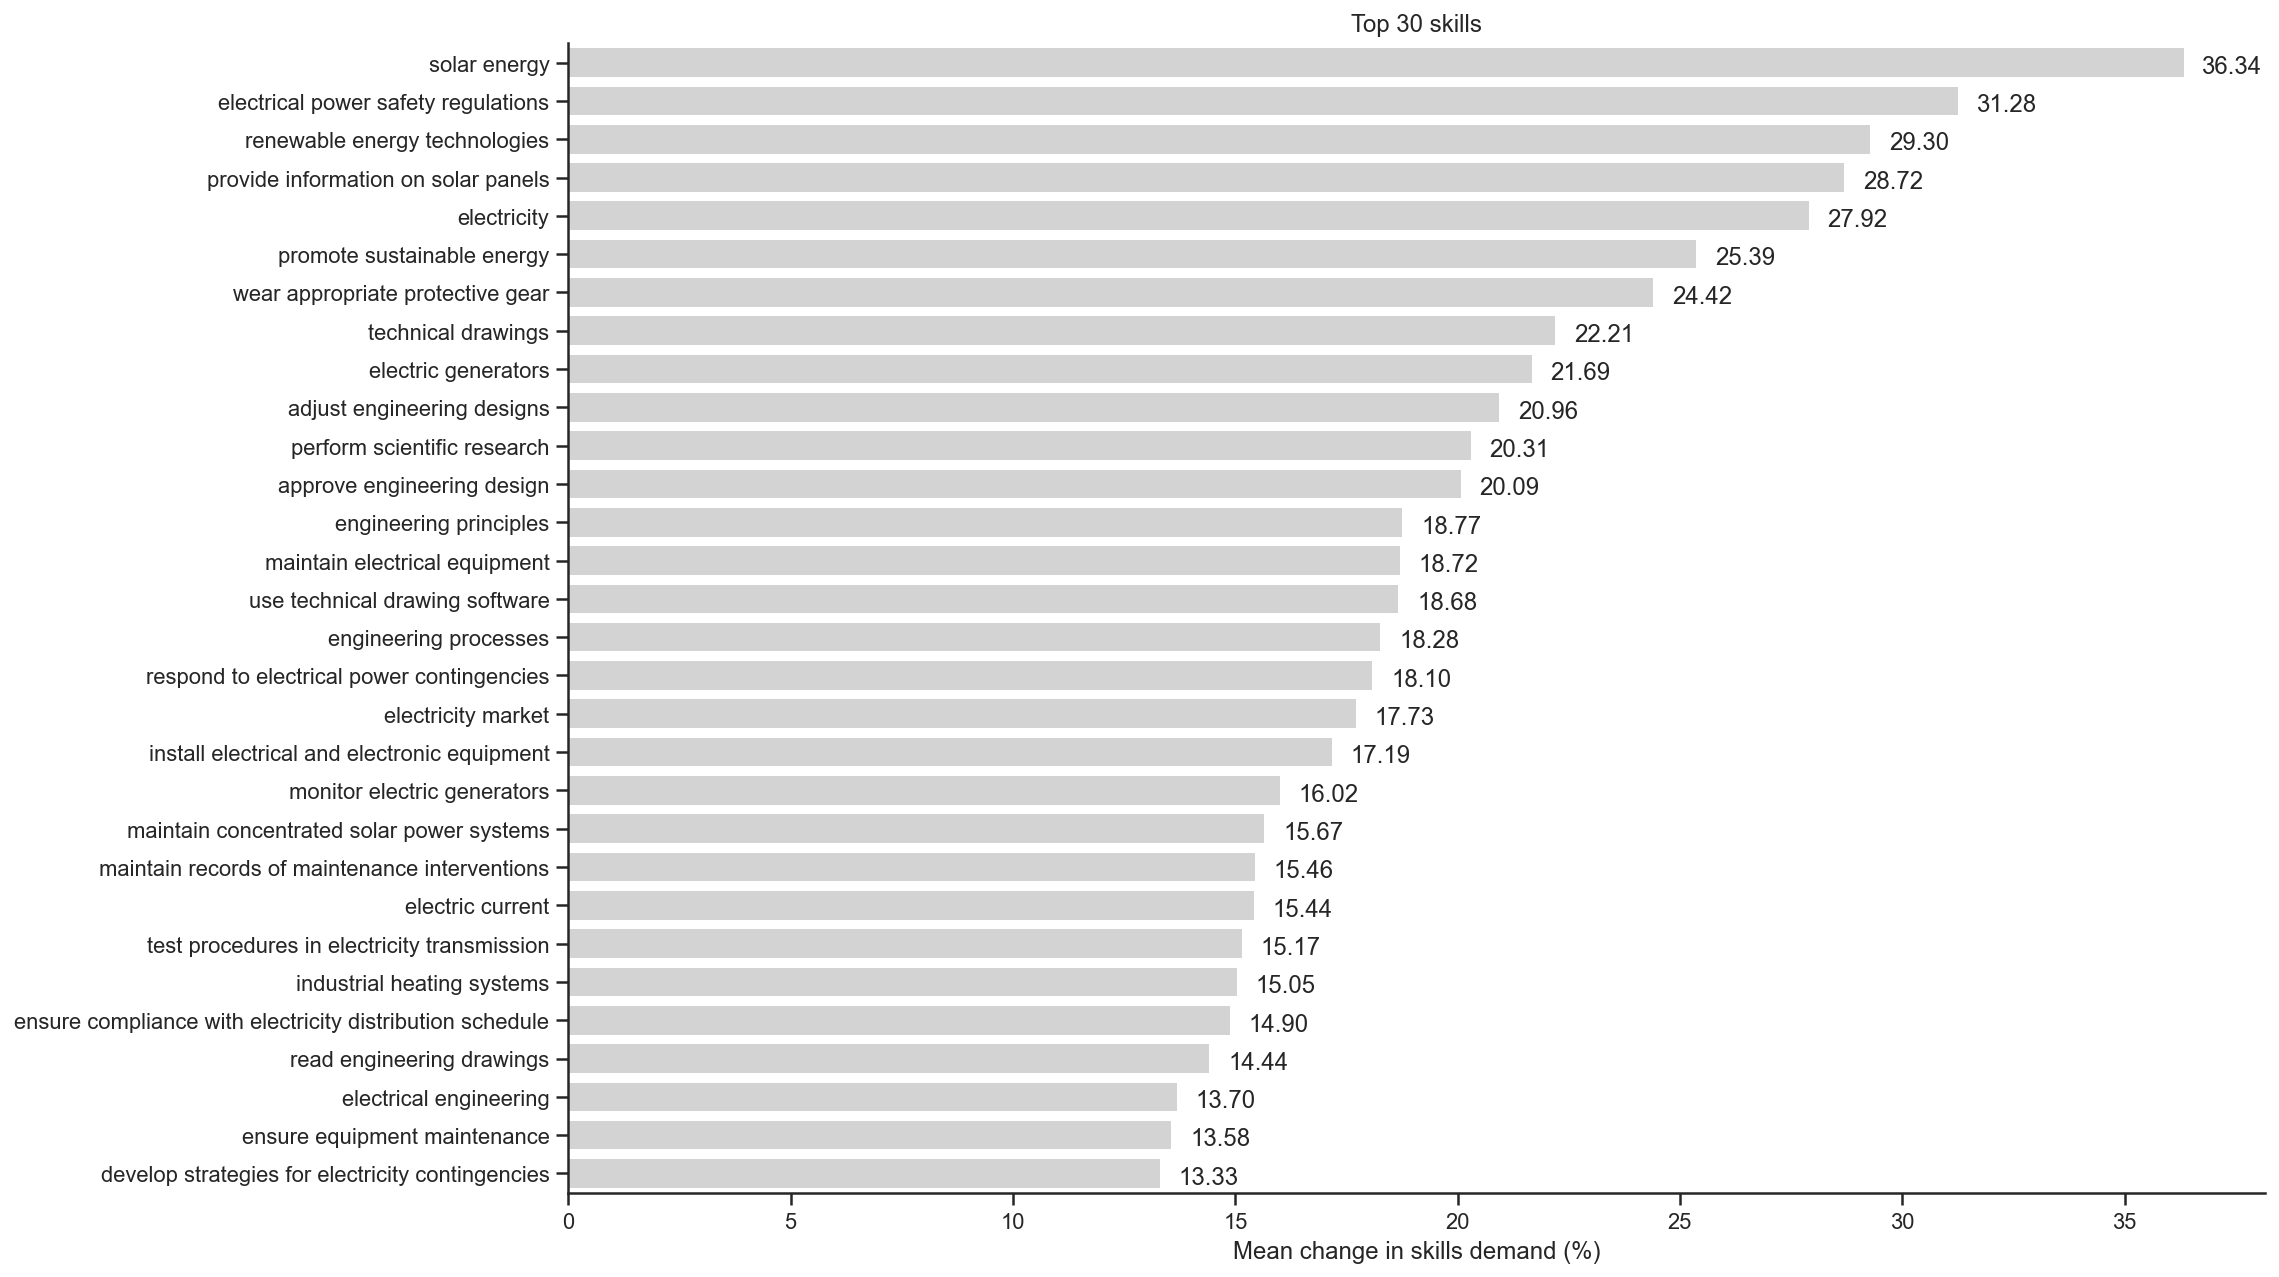

In [85]:
ax = sns.barplot(
    data=skills.sort_values("tes_pc_2019_2030_mean", ascending=False).head(30),
    y="preferredLabel",
    x="tes_pc_2019_2030_mean",
    orient="h",
    color="lightgrey"
)

ax.set_xlabel("Mean change in skills demand (%)")
ax.set_ylabel(None)
ax.set_title("Top 30 skills")

show_values_on_bars(ax, h_v="h")

plt.tight_layout()
sns.despine()

plt.savefig(
    os.path.join(figure_dir, "iea_scenario", "top_30_skills.png"),
    bbox_inches="tight",
    dpi=150
)

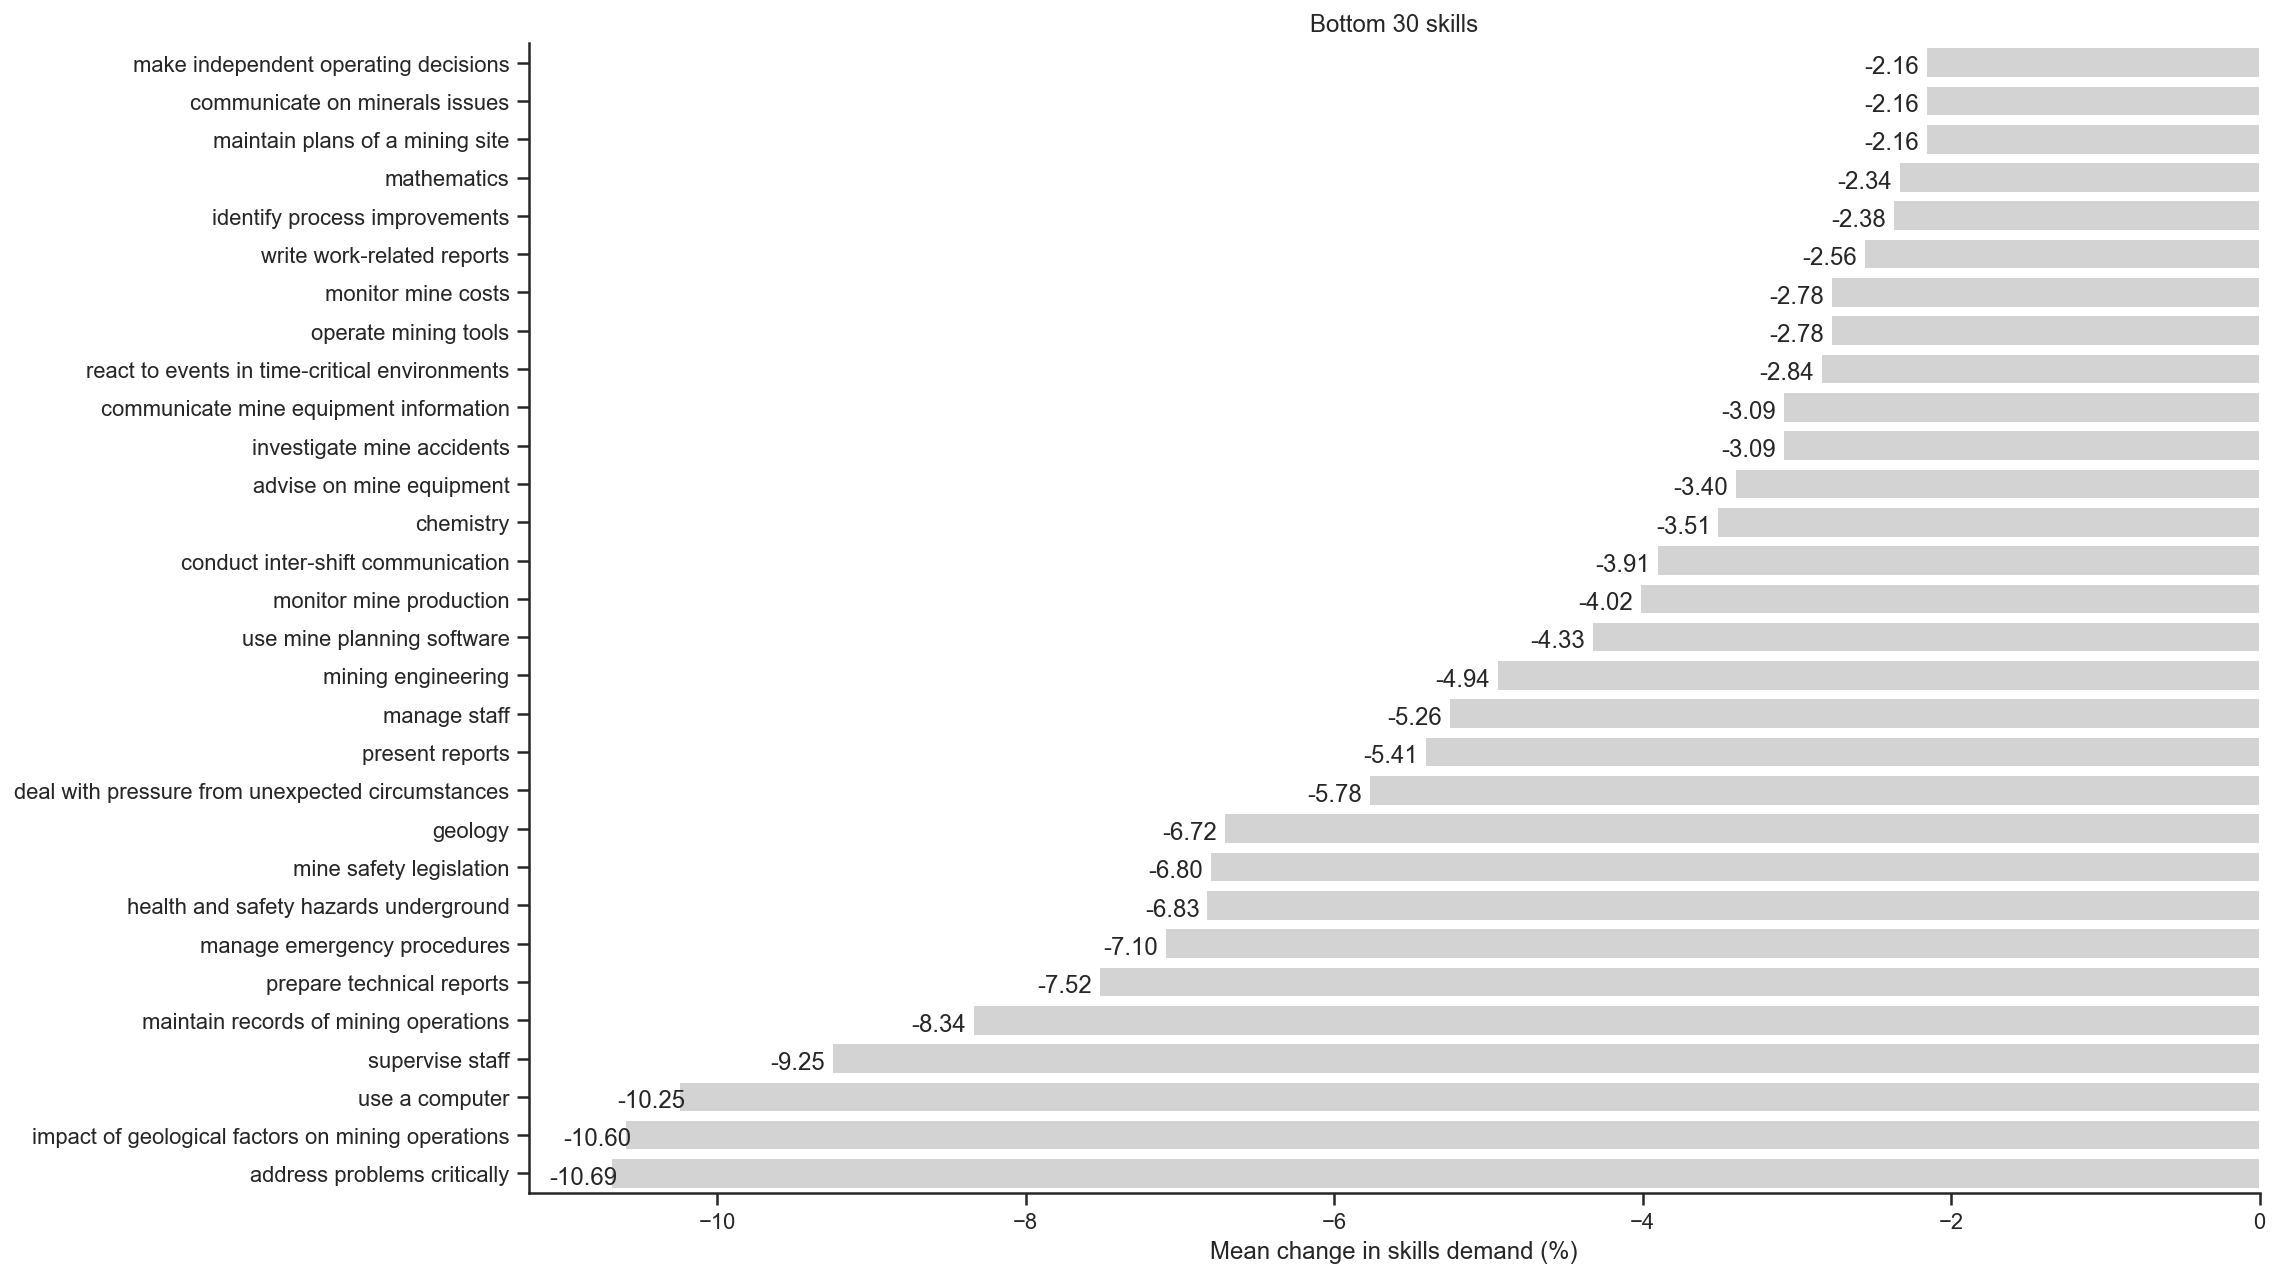

In [86]:
ax = sns.barplot(
    data=skills.sort_values("tes_pc_2019_2030_mean", ascending=False).tail(30),
    y="preferredLabel",
    x="tes_pc_2019_2030_mean",
    orient="h",
    color="lightgrey"
)

ax.set_xlabel("Mean change in skills demand (%)")
ax.set_ylabel(None)
ax.set_title("Bottom 30 skills")

show_values_on_bars(ax, h_v="h", space=-0.4)

plt.tight_layout()
sns.despine()

plt.savefig(
    os.path.join(figure_dir, "iea_scenario", "bottom_30_skills.png"),
    bbox_inches="tight",
    dpi=150
)

In [87]:
#skills.sort_values("tes_pc_2019_2030_mean", ascending=False).tail(30).preferredLabel

In [88]:
selection = [
    "solar energy", "renewable energy technologies", "engineering principles",
    "operate mining tools", "mining engineering", "manage emergency procedures"
]

vars = [
    "preferredLabel",
    "tes_pc_2019_2020_mean", "tes_pc_2019_2030_mean",
    "tes_pc_2019_2040_mean", "tes_pc_2019_2050_mean"
]

skills_sel = skills.loc[skills.preferredLabel.isin(selection)]

In [89]:
skills_sel2 = skills_sel[vars]

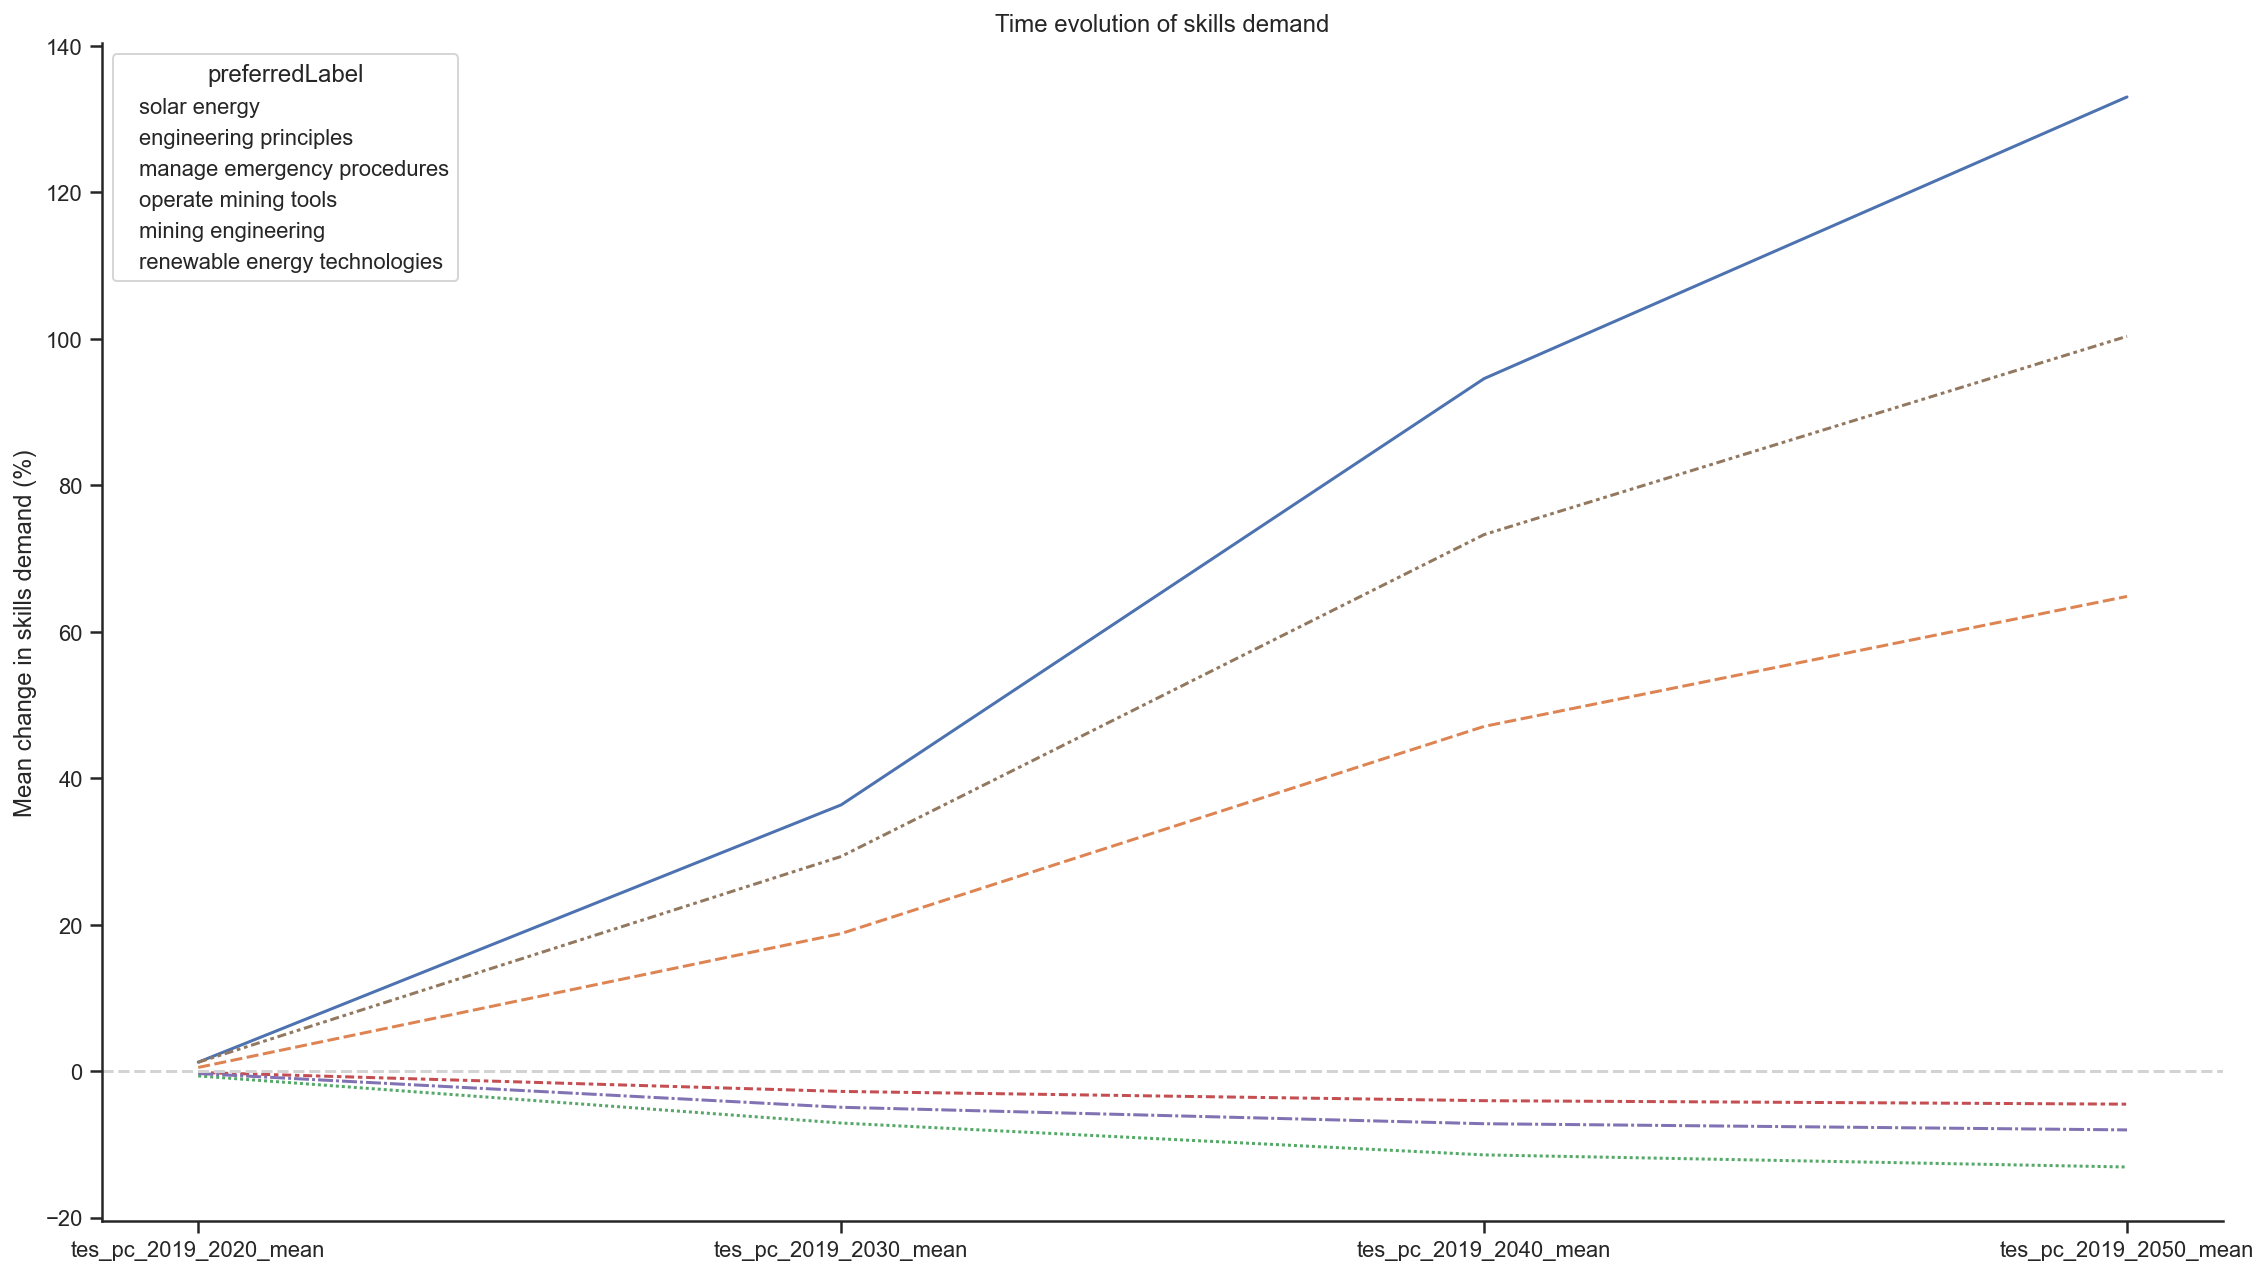

In [90]:
ax = sns.lineplot(
    data=skills_sel2.set_index("preferredLabel").transpose()
)

ax.set_xlabel(None)
ax.set_ylabel("Mean change in skills demand (%)")
ax.set_title("Time evolution of skills demand")
ax.axhline(0, linestyle="--", color="lightgrey")

plt.tight_layout()
sns.despine()

plt.savefig(
    os.path.join(figure_dir, "iea_scenario", "time_evolution_example.png"),
    bbox_inches="tight",
    dpi=150
)

#### Visualise change in demand for occupations

In [91]:
cols = ['preferred_label', 'tes_pc_2019_2020', 'tes_pc_2019_2030',
       'tes_pc_2019_2040', 'tes_pc_2019_2050']

df_iea_sub = df_iea[cols]

df_iea_sub[df_iea_sub.select_dtypes(include=['number']).columns] *= 100

/Users/felix/Applications/miniconda3/envs/da/lib/python3.8/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [92]:
names1 = {
    "preferred_label": "occupation",
    "tes_pc_2019_2020": 2020,
    "tes_pc_2019_2030": 2030,
    "tes_pc_2019_2040": 2040,
    "tes_pc_2019_2050": 2050
}

ts_iea_sub = df_iea_sub.rename(columns=names1).set_index("occupation")
ts_iea_sub[2019] = np.zeros(len(ts_iea_sub))
ts_iea_sub = ts_iea_sub[[2019, 2020, 2030, 2040, 2050]]
ts_iea_sub = ts_iea_sub.T

<Figure size 1152x648 with 0 Axes>

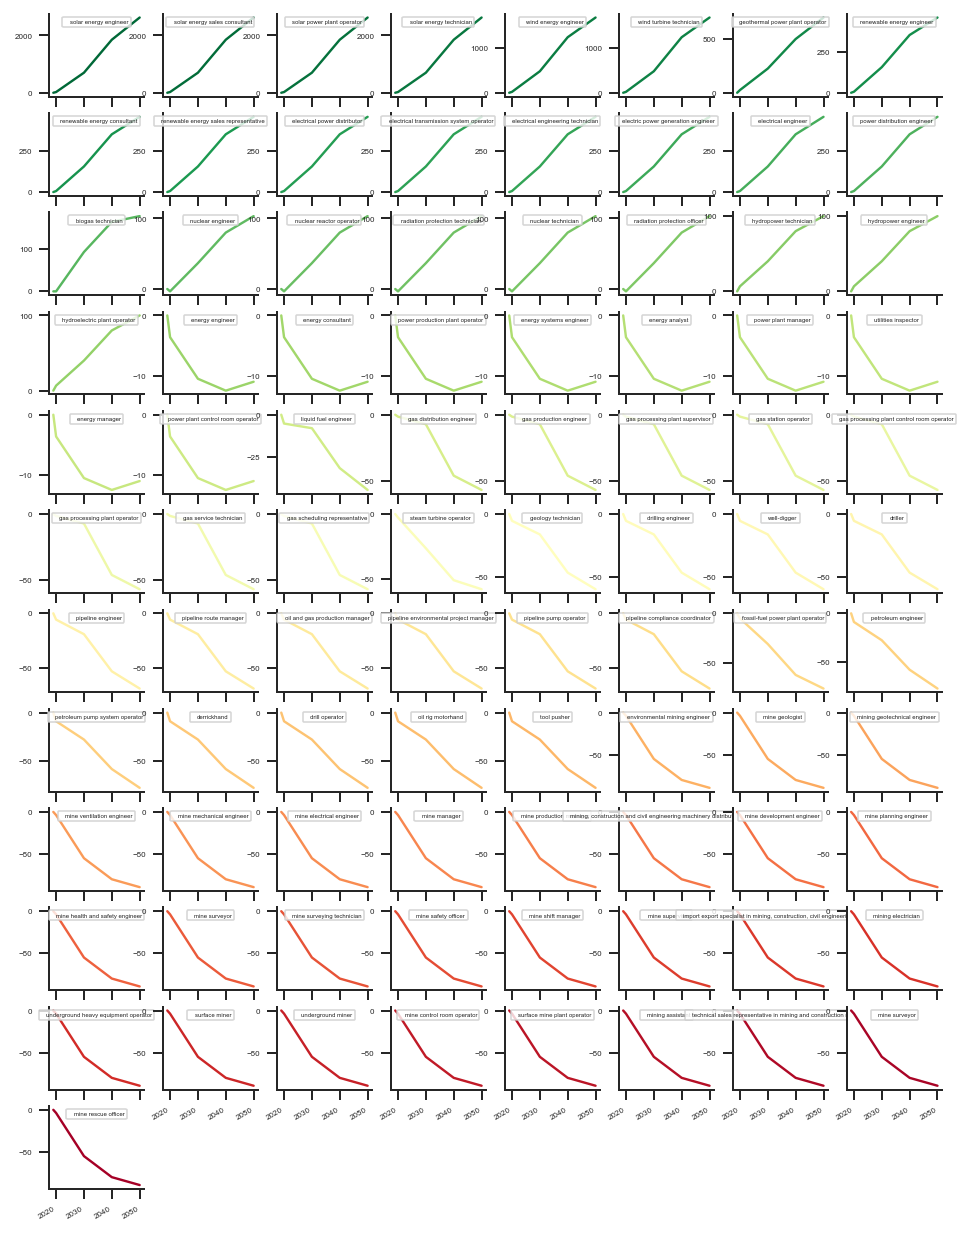

In [93]:
sns.set_context("paper")

params = {'legend.fontsize': 3,
          'legend.handlelength': 0}
plt.rcParams.update(params)

fig = plt.figure()

axes = ts_iea_sub.plot(
    subplots=True,
    layout=(12, 8),
    figsize=(8, 12),
    #legend=False,
    fontsize=4,
    #color="grey",
    cmap="RdYlGn_r",
    xticks=[2020, 2030, 2040, 2050]
)

sns.despine()

for ax in axes.flatten():
    ax.legend(loc='upper center')
    ax.set_xticks([], minor=True)

plt.savefig(
    os.path.join(figure_dir, "iea_scenario", "tes_pc_occupation_time.png"),
    bbox_inches="tight",
    dpi=300
)

#### Version 2
- 3 panels: increasing, slightly decreasing, decreasing
- same y axis per row

In [94]:
colors = {}
for i in np.arange(0, 89):
    # increasing
    if i <= 24:
        colors[i] = "green"
    elif 24 < i < 34:
        colors[i] = "orange"
    elif 34 <= i < 61:
        colors[i] = "red"
    else:
        colors[i] = "darkred"

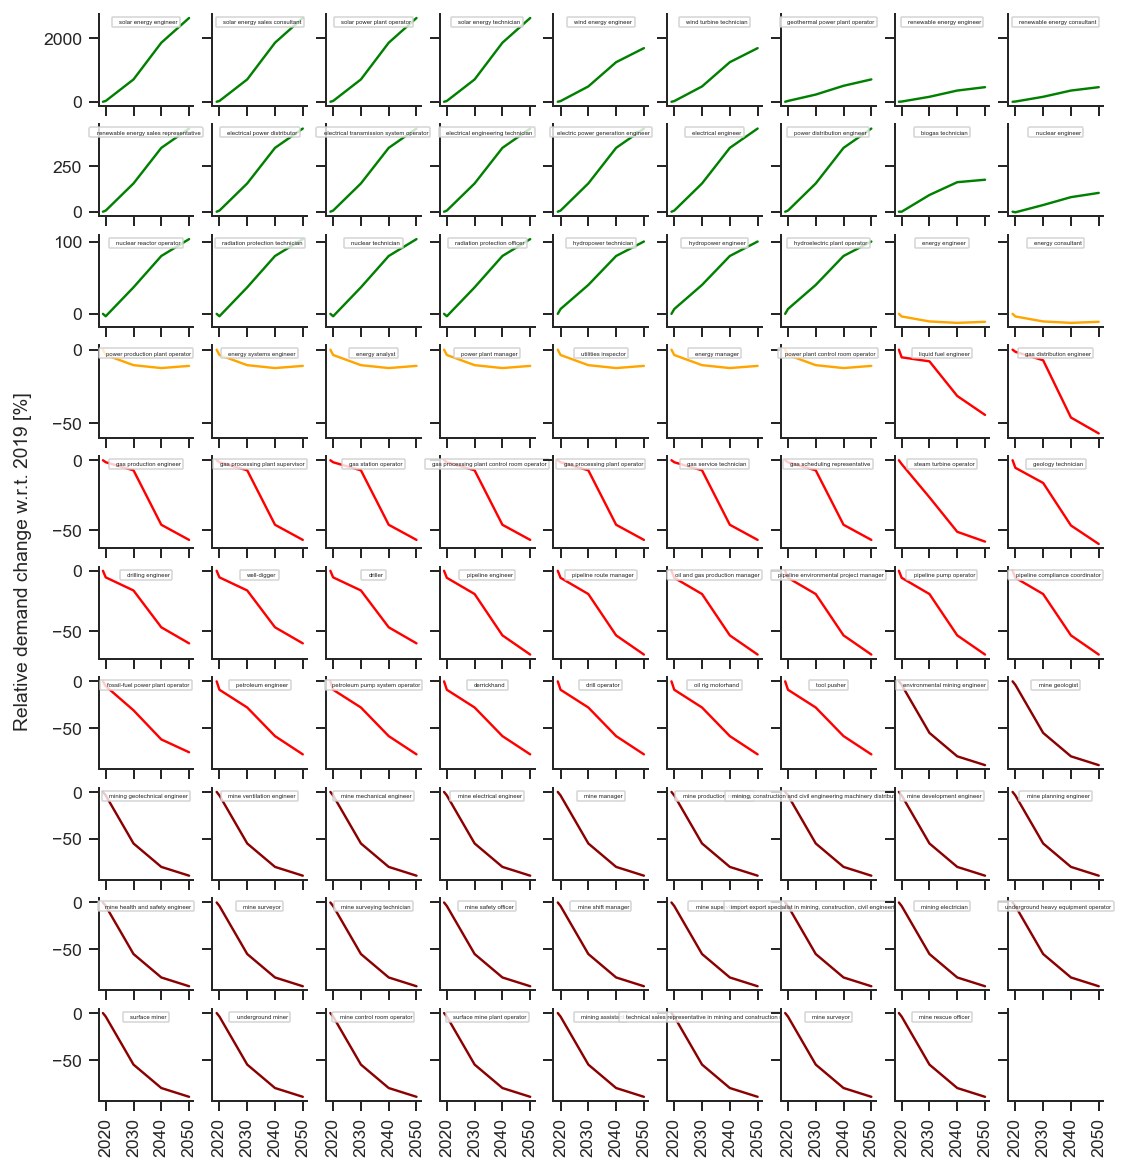

In [95]:
r, c = 10, 9
fig, axes = plt.subplots(
    nrows=r, ncols=c, figsize=(c, r), sharey="row", sharex=True
)

for i, ax in enumerate(axes.flatten()):

    if i < ts_iea_sub.shape[1]:
        ts_iea_sub.iloc[:, i].plot(ax=ax, color=colors[i])
        ax.legend(loc='upper center', fontsize=3)

    ax.set_xticks([], minor=True)
    ax.set_xticks([2020, 2030, 2040, 2050], minor=False)
    ax.tick_params(axis='x', rotation=90)

fig.text(0.06, 0.5, 'Relative demand change w.r.t. 2019 [%]', va='center', rotation='vertical')
sns.despine()

plt.savefig(
    os.path.join(figure_dir, "iea_scenario", "tes_pc_occupation_time_v2.png"),
    bbox_inches="tight",
    dpi=300
)

#### Comparison with ILO Scenario results

In [96]:
df_metadata = pd.read_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA_gbn.csv"),
    index_col=0
)

df_metadata

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,isco_level_1,isco_level_2,isco_level_3,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018,greenness_vona_2018_v2,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training,skill_level_ilo,new_jobs_absorbing_ilo_2030_es,new_jobs_net_ilo_2030_es,jobs_lost_net_ilo_2030_es,jobs_lost_reallocated_ilo_2030_es,net_change_ilo_2030_es,new_jobs_absorbing_ilo_2030_ce,new_jobs_net_ilo_2030_ce,jobs_lost_net_ilo_2030_ce,jobs_lost_reallocated_ilo_2030_ce,net_change_ilo_2030_ce,is_brown,is_green,is_neutral
0,0,http://data.europa.eu/esco/occupation/00030d09...,technical director,2166,27-1011.00,art directors,2,21,216,Non Green,NaN,NaN,NaN,NaN,0.0000,36.670202,37555.308176,NaN,NaN,4.0,6.2477,8.0309,4.3843,H,500000.0,263000.0,-253000.0,-500000.0,10000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,False,False,True
1,1,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,8121,51-4021.00,"extruding and drawing machine setters, operato...",8,81,812,Non Green,NaN,NaN,NaN,NaN,0.0000,39.904110,22031.963636,0.000020,645.0,2.0,2.1163,2.4383,3.6486,M,339000.0,712000.0,-34000.0,-339000.0,678000.0,2913000.0,500.0,-5589000.0,-2913000.0,-5588500.0,True,False,False
2,2,http://data.europa.eu/esco/occupation/0019b951...,precision device inspector,7543,51-9061.00,"inspectors, testers, sorters, samplers, and we...",7,75,754,Green Enhanced Skills,2.0,0.0,30.0,0.066667,0.0625,38.709386,22430.367647,NaN,NaN,2.0,2.5397,4.8863,4.0288,M,48000.0,316000.0,-500.0,-48000.0,315500.0,1315000.0,408000.0,-440000.0,-1315000.0,-32000.0,False,True,False
3,3,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,3155,17-3023.01,electronics engineering technicians,3,31,315,Non Green,NaN,NaN,NaN,NaN,0.0000,42.036716,32754.000000,0.000087,2797.0,3.0,4.3848,5.4808,4.0782,H,748000.0,528000.0,-206000.0,-748000.0,322000.0,3042000.0,1225000.0,-965000.0,-3042000.0,260000.0,False,False,True
4,4,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,2431,13-1161.00,market research analysts and marketing special...,2,24,243,Non Green,NaN,NaN,NaN,NaN,0.0000,36.354676,38839.816377,0.000648,20834.0,4.0,6.8261,6.3481,3.8265,H,218000.0,147000.0,-75000.0,-218000.0,72000.0,823000.0,837000.0,-53000.0,-823000.0,784000.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2937,http://data.europa.eu/esco/occupation/ff656b3a...,demographer,2120,15-2041.00,statisticians,2,21,212,Non Green,NaN,NaN,NaN,NaN,0.0000,35.494487,36135.290249,0.000286,9184.0,5.0,8.3000,5.5000,4.6000,H,500000.0,263000.0,-253000.0,-500000.0,10000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,False,False,True
2917,2938,http://data.europa.eu/esco/occupation/ff8d4065...,sorter labourer,9612,51-9199.01,recycling and reclamation workers,9,96,961,New Green N&E,18.0,0.0,0.0,1.000000,1.0000,39.443972,21357.054545,0.000417,13414.0,2.0,3.1532,3.3559,2.8314,L,153000.0,305000.0,-17000.0,-153000.0,288000.0,860000.0,1152000.0,-111000.0,-860000.0,1041000.0,False,True,False
2918,2939,http://data.europa.eu/esco/occupation/ffa4dd5d...,armoured car guard,5414,33-9032.00,security guards,5,54,541,Non Green,NaN,NaN,NaN,NaN,0.0000,37.021429,24315.540984,NaN,NaN,2.0,2.2215,3.2642,2.0230,M,141000.0,179000.0,-27000.0,-141000.0,152000.0,744000.0,579000.0,-497000.0,-744000.0,82000.0,False,False,True
2919,2940,http://data.europa.eu/esco/occupation/ffade2f4...,civil service administrative officer,2422,11-3011.00,administrative services managers,2,24,242,Non Green,NaN,NaN,NaN,NaN,0.0000,35.240566,33292.986333,0.001128,36261.0,3.0,3.9636,6.9711,3.4248,H,218000.0,147000.0,-75000.0,-218000.0,72000.0,823000.0,837000.0,-53000.0,-823000.0,784000.0,False,False,True


In [97]:
df_merged = pd.merge(
    df_iea_sub.rename(columns=names1)[["occupation", 2030]],
    df_metadata[["preferred_label", "net_change_ilo_2030_es", "net_change_ilo_2030_ce", "isco_level_2"]],
    left_on="occupation",
    right_on="preferred_label",
    how="left"
).drop(columns=["preferred_label"]).set_index("occupation")

In [98]:
names2 = {
    2030: "IEA NZE 2030",
    "net_change_ilo_2030_es": "ILO ES 2030",
    "net_change_ilo_2030_ce": "ILO CE 2030"
}
df_merged = df_merged.rename(columns=names2)
df_merged["isco_level_2"] = pd.Categorical(df_merged["isco_level_2"])

In [99]:
import pingouin as pg

df_merged.rcorr(method="pearson")

,IEA NZE 2030,ILO ES 2030,ILO CE 2030
IEA NZE 2030,-,,*
ILO ES 2030,-0.042,-,***
ILO CE 2030,0.235,-0.546,-


In [100]:
pval_stars = {0.01: '***', 0.05: '**', 0.1: '*'}
corr_pearson = df_merged.rcorr(method="pearson", pval_stars=pval_stars)
corr_spearman = df_merged.rcorr(method="spearman", pval_stars=pval_stars)

In [101]:
corr_pearson.to_csv(
    os.path.join(data_processed, "iea_ilo_comparison_pearson.csv")
)

corr_spearman.to_csv(
    os.path.join(data_processed, "iea_ilo_comparison_spearman.csv")
)

#### Extended analysis with all ILO variables
Note: *p<0.1, **p<0.05, ***p<0.01

In [102]:
df_metadata.columns

Index(['id', 'concept_uri', 'preferred_label', 'isco_level_4', 'onet_code',
       'onet_occupation', 'isco_level_1', 'isco_level_2', 'isco_level_3',
       'occupation_type', 'n_new_green_tasks', 'n_existing_green_tasks',
       'n_non_green_tasks', 'greenness_vona_2018', 'greenness_vona_2018_v2',
       'total_paid_hours', 'annual_earnings', 'employment_share',
       'employment_count', 'job_zone', 'education_level',
       'related_work_experience', 'on_the_job_training', 'skill_level_ilo',
       'new_jobs_absorbing_ilo_2030_es', 'new_jobs_net_ilo_2030_es',
       'jobs_lost_net_ilo_2030_es', 'jobs_lost_reallocated_ilo_2030_es',
       'net_change_ilo_2030_es', 'new_jobs_absorbing_ilo_2030_ce',
       'new_jobs_net_ilo_2030_ce', 'jobs_lost_net_ilo_2030_ce',
       'jobs_lost_reallocated_ilo_2030_ce', 'net_change_ilo_2030_ce',
       'is_brown', 'is_green', 'is_neutral'],
      dtype='object')

In [103]:
ilo_cols = ["preferred_label", 'new_jobs_absorbing_ilo_2030_es', 'new_jobs_net_ilo_2030_es',
       'jobs_lost_net_ilo_2030_es', 'jobs_lost_reallocated_ilo_2030_es',
       'net_change_ilo_2030_es', 'new_jobs_absorbing_ilo_2030_ce',
       'new_jobs_net_ilo_2030_ce', 'jobs_lost_net_ilo_2030_ce',
       'jobs_lost_reallocated_ilo_2030_ce', 'net_change_ilo_2030_ce']

df_merged2 = pd.merge(
    df_iea_sub.rename(columns=names1)[["occupation", 2030]],
    df_metadata[ilo_cols],
    left_on="occupation",
    right_on="preferred_label",
    how="left"
).drop(columns=["preferred_label"]).set_index("occupation")

In [104]:
df_merged2.rcorr(method="pearson", pval_stars=pval_stars)

,2030,new_jobs_absorbing_ilo_2030_es,new_jobs_net_ilo_2030_es,jobs_lost_net_ilo_2030_es,jobs_lost_reallocated_ilo_2030_es,net_change_ilo_2030_es,new_jobs_absorbing_ilo_2030_ce,new_jobs_net_ilo_2030_ce,jobs_lost_net_ilo_2030_ce,jobs_lost_reallocated_ilo_2030_ce,net_change_ilo_2030_ce
2030,-,,,,,,,**,**,,**
new_jobs_absorbing_ilo_2030_es,0.024,-,,***,***,**,***,***,*,***,***
new_jobs_net_ilo_2030_es,-0.045,-0.106,-,***,,***,***,***,***,***,***
jobs_lost_net_ilo_2030_es,-0.006,-0.737,0.379,-,***,***,,***,***,,***
jobs_lost_reallocated_ilo_2030_es,-0.024,-1.0,0.106,0.737,-,**,***,***,*,***,***
net_change_ilo_2030_es,-0.042,-0.234,0.985,0.532,0.234,-,***,***,***,***,***
new_jobs_absorbing_ilo_2030_ce,-0.117,0.65,0.41,-0.05,-0.65,0.365,-,,***,***,***
new_jobs_net_ilo_2030_ce,0.271,0.549,-0.296,-0.662,-0.549,-0.394,-0.121,-,***,,***
jobs_lost_net_ilo_2030_ce,0.212,0.207,-0.505,-0.521,-0.207,-0.559,-0.501,0.757,-,***,***
jobs_lost_reallocated_ilo_2030_ce,0.117,-0.65,-0.41,0.05,0.65,-0.365,-1.0,0.121,0.501,-,***


In [105]:
df_merged2.rcorr(method="spearman", pval_stars=pval_stars)

,2030,new_jobs_absorbing_ilo_2030_es,new_jobs_net_ilo_2030_es,jobs_lost_net_ilo_2030_es,jobs_lost_reallocated_ilo_2030_es,net_change_ilo_2030_es,new_jobs_absorbing_ilo_2030_ce,new_jobs_net_ilo_2030_ce,jobs_lost_net_ilo_2030_ce,jobs_lost_reallocated_ilo_2030_ce,net_change_ilo_2030_ce
2030,-,**,,,**,,,*,**,,*
new_jobs_absorbing_ilo_2030_es,0.209,-,,***,***,,***,**,,***,
new_jobs_net_ilo_2030_es,-0.048,0.132,-,***,,***,***,***,***,***,***
jobs_lost_net_ilo_2030_es,-0.089,-0.527,0.62,-,***,***,,***,***,,***
jobs_lost_reallocated_ilo_2030_es,-0.209,-1.0,-0.132,0.527,-,,***,**,,***,
net_change_ilo_2030_es,-0.042,-0.022,0.941,0.766,0.022,-,***,***,***,***,***
new_jobs_absorbing_ilo_2030_ce,0.105,0.757,0.715,0.064,-0.757,0.587,-,,***,***,***
new_jobs_net_ilo_2030_ce,0.186,0.271,-0.444,-0.704,-0.271,-0.516,-0.163,-,***,,***
jobs_lost_net_ilo_2030_ce,0.226,-0.153,-0.723,-0.405,0.153,-0.627,-0.588,0.724,-,***,***
jobs_lost_reallocated_ilo_2030_ce,-0.105,-0.757,-0.715,-0.064,0.757,-0.587,-1.0,0.163,0.588,-,***


#### Robustness checks
- wie viele ISCO-08 2-digit level gruppen vertreten?
- wie verteilt?

In [106]:
df_merged[["ILO CE 2030", "ILO ES 2030"]] /= 10**6

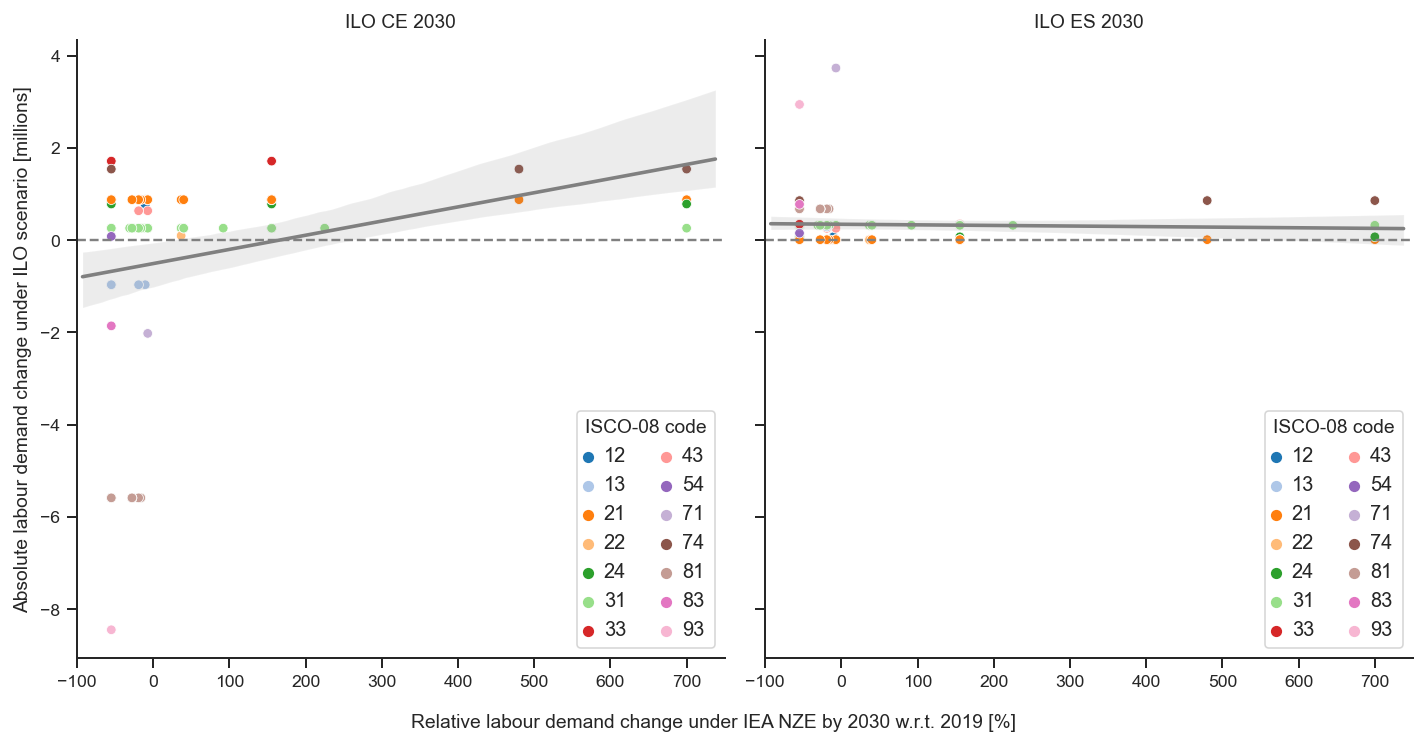

In [113]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=True, sharex=True)

for ax, scenario in zip(axes, ["ILO CE 2030", "ILO ES 2030"]):
    sns.scatterplot(
        x="IEA NZE 2030",
        y=scenario,
        hue="isco_level_2",
        palette="tab20",
        data=df_merged,
        ax=ax
    )

    sns.regplot(
        x="IEA NZE 2030",
        y=scenario,
        scatter=False,
        color="grey",
        robust=False,
        truncate=False,
        data=df_merged,
        ax=ax
    )

    ax.set_title(scenario)
    ax.set_xlabel(None)
    ax.axhline(0, linestyle="--", color="grey")
    ax.legend(fontsize = 10, loc="lower right", ncol=2, title="ISCO-08 code")

axes[0].set_ylabel("Absolute labour demand change under ILO scenario [millions]")
fig.text(0.5, -0.02, "Relative labour demand change under IEA NZE by 2030 w.r.t. 2019 [%]", ha='center')

plt.xlim(-100, 750)

sns.despine()
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "iea_scenario", "ilo_iea_comparison_regplot.png"),
    bbox_inches="tight",
    dpi=300
)

In [120]:
from stargazer.stargazer import Stargazer

reg = sm.OLS(
    endog=df_merged["IEA NZE 2030"].values,
    exog=df_merged["ILO CE 2030"].values
).fit(cov_type='HC3')

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.035
Model:                            OLS   Adj. R-squared (uncentered):              0.024
Method:                 Least Squares   F-statistic:                              11.19
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                     0.00121
Time:                        14:22:22   Log-Likelihood:                         -585.64
No. Observations:                  89   AIC:                                      1173.
Df Residuals:                      88   BIC:                                      1176.
Df Model:                           1                                                  
Covariance Type:                  HC3                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            14.4570      4.322      3.345      0.001       5.987      22.927
==============================================================================
Omnibus:                       71.161   Durbin-Watson:                   0.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.296
Skew:                           2.774   Prob(JB):                     4.63e-70
Kurtosis:                      10.437   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC3)
"""